# Pipeline Steps

### Pre-Step: Calibrate the camera to get the camera matrix and distortion coefficients
 
### Pipeline
 1. Undistort the image
 2. Threshold the image using gradients and colors
 3. Apply a Perspective Transform to view the image from top-down
 4. Identify the lane lines in warped image
 5. Un-transform back to orginal perspective and draw lane and lines

### Pre-Step: Calibrate the Camera

Before can begin developing the pipeline for decting lane lines, we need to account for the distortion in our camera. To do that, we need some information about the camera - we need to calibrate it.

By inspecting pictures of a chessboard pattern (predictable/known pattern) we can find the distoration coefficients and camera matrix that we need to undistort images.

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
ret, cMat, coefs, rvects, tvects = None, None, None, None, None

def calibrate_camera():
    im_paths = glob.glob('./camera_cal_images/calibration*.jpg')

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    obj_points = []  # 3D points in real-world space
    img_points = []  # 2D points in the image

    for im_path in im_paths:
        img = mpimg.imread(im_path)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found_all, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if found_all:
            obj_points.append(obj_p)
            img_points.append(corners)
            img = cv2.drawChessboardCorners(img, cb_shape, corners, found_all)
        else:
            print("Couldn't find all corners in image:", im_path)
    
    return cv2.calibrateCamera(obj_points, img_points, gray.shape, None, None)
    
ret, cMat, coefs, rvects, tvects = calibrate_camera()
print(coefs)

[[ -2.47539663e-01  -1.51847046e-02  -1.18700379e-03  -2.48437227e-05
   -3.05600547e-02]]


#### Helper Plotting Functions

In [3]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(im1)
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    ax2.imshow(im2)
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

### Step 1: Undistort Images

Now we should be able to undistort images. Let's give it a try.

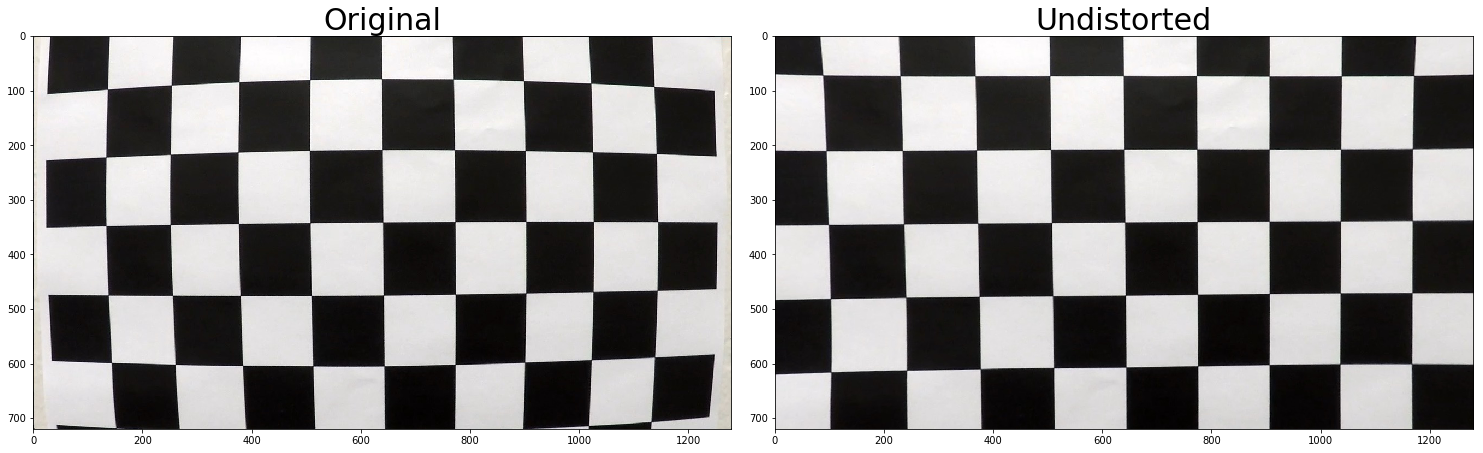

In [4]:
def undistort(img):
    if cMat is None: raise Exception('The camera needs to be calibrated first.')
    
    return cv2.undistort(img, cMat, coefs, None, cMat)
    
    
test_undistort = mpimg.imread('./camera_cal_images/not_enough_corners/calibration1.jpg')
undistorted = undistort(test_undistort)
side_by_side_plot(test_undistort, undistorted, 'Original', 'Undistorted')

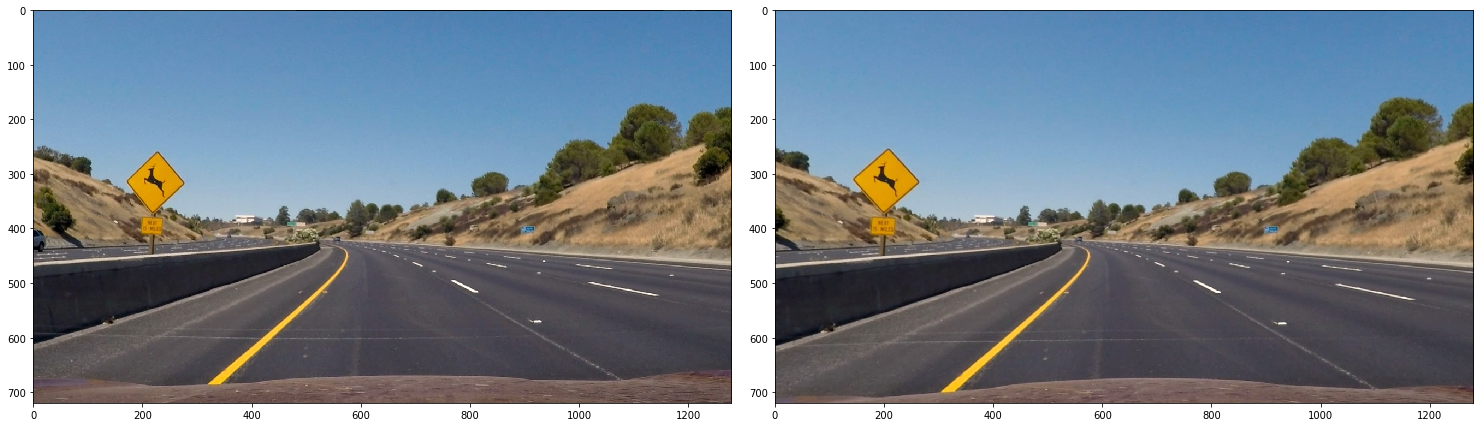

In [5]:
img = mpimg.imread('./test_images/test2.jpg')
undistorted = undistort(img)
side_by_side_plot(img, undistorted)

Both the chessboard and the road images above show the distorted (left) and undistorted (right). It's much easier to see the effect in the chessbaord image with all those parallel lines, but there are some signs in the road image like the yellow line, the hood of the car at the bottom, and the white car on the right.

### Step 2: Thresholding

With a way to undistort our distorted camera images, we now need a good thresholding method that will utilize gradients and colors to detect the lane lines in the image.

Let's create a thresholding function.

In [6]:
def get_sobel_bin(img):
    ''' "img" should be 1-channel '''
    
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)  # x-direction gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_bin = np.zeros_like(scaled_sobel)
    sobel_bin[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1
    
    return sobel_bin

def get_threshold(img, show=False):
    ''' "img" should be an undistorted image ''' 
    
    # Color-space conversions
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Sobel gradient binaries
    sobel_s_bin = get_sobel_bin(s_channel)
    sobel_gray_bin = get_sobel_bin(gray)
    
    sobel_comb_bin = np.zeros_like(sobel_s_bin)
    sobel_comb_bin[(sobel_s_bin == 1) | (sobel_gray_bin == 1)] = 1
    
    # HLS S-Channel binary
    s_bin = np.zeros_like(s_channel)
    s_bin[(s_channel >= 150) & (s_channel <= 255)] = 1
    
    # Combine the binaries
    comb_bin = np.zeros_like(sobel_comb_bin)
    comb_bin[(sobel_comb_bin == 1) | (s_bin == 1)] = 1
    
    gray_img = np.dstack((gray, gray, gray))
    sobel_s_img = np.dstack((sobel_s_bin, sobel_s_bin, sobel_s_bin))*255
    sobel_gray_img = np.dstack((sobel_gray_bin, sobel_gray_bin, sobel_gray_bin))*255
    sobel_comb_img = np.dstack((sobel_comb_bin, sobel_comb_bin, sobel_comb_bin))*255
    s_img = np.dstack((s_bin, s_bin, s_bin))*255
    comb_img = np.dstack((comb_bin, comb_bin, comb_bin))*255
    
    if show: side_by_side_plot(img, comb_img, 'Original', 'Thresholded')
    
    return comb_img

Great! Looks like the thresholding method works.

Thresholding seemed to perform best using a combination of the s-channel from HLS color space and the combined sobel-gradient. The combined sobel gradient was created from both grayscale and s-channel images, since they both provided different, useful information.

We will combine this with the undistort method.

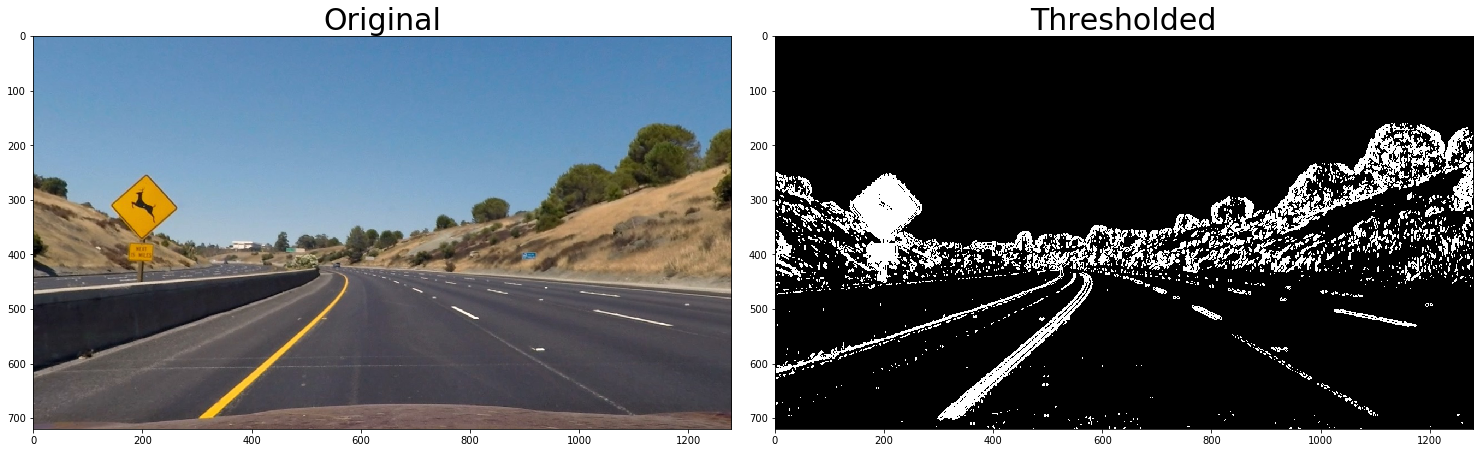

In [7]:
img = mpimg.imread('./test_images/test2.jpg')
undist = undistort(img)
threshold_img = get_threshold(undist, show=True)

### Step 3: Perspective Transform

Now that we can undistort images and threshold them to help isolate the important information, we need to further limit that information by looking only at the portion of the image we care about - the road.

To focus in on the road portion of the image we will shift our perspective to a top-down view of the road in front of the car. To test this function, we'll use a road image with straight lines.

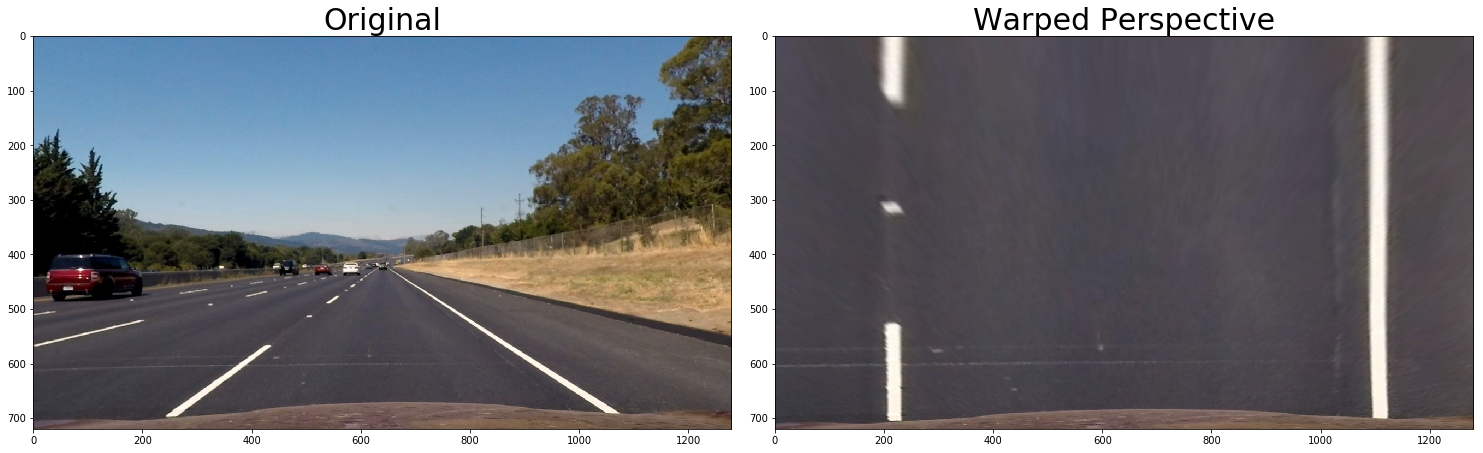

In [8]:
def warp_to_lines(img, show=False):
    ''' "img" should be an undistorted image. '''
    
    x_shape, y_shape = img.shape[1], img.shape[0]
    middle_x = x_shape//2
    top_y = 2*y_shape//3
    top_margin = 93
    bottom_margin = 450
    points = [
        (middle_x-top_margin, top_y),
        (middle_x+top_margin, top_y),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ]

    '''
    # This shows the area we are warping to
    for i in range(len(points)):
        cv2.line(img, points[i-1], points[i], [255, 0, 0], 2)

    big_plot(img)
    '''

    src = np.float32(points)
    dst = np.float32([
        (middle_x-bottom_margin, 0),
        (middle_x+bottom_margin, 0),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (x_shape, y_shape), flags=cv2.INTER_LINEAR)
    
    if show: side_by_side_plot(img, warped, 'Original', 'Warped Perspective')
        
    return warped, M, Minv

img = mpimg.imread('./test_images/straight_lines2.jpg')
img = undistort(img)
warped, M, Minv = warp_to_lines(img, show=True)

Great! We now have a function that can warp our perspective from a forward-facing road image to a top-down roade image. The warped image will be perfect for isolating lane lines and measuring any curvature.

We will be applying this perspective warp to thresholded images.

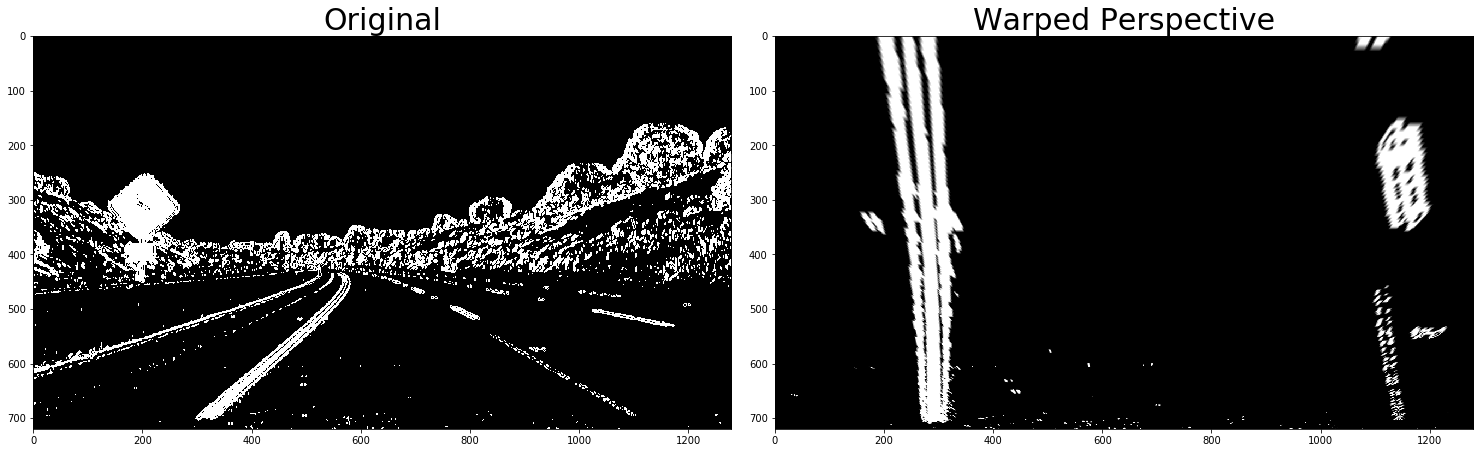

In [9]:
img = mpimg.imread('./test_images/test2.jpg')
undist = undistort(img)
thresholded = get_threshold(undist)
warped, M, Minv = warp_to_lines(thresholded, show=True)

### Step 4: Identify the Lanes

With the undistortion, thresholding, and perspective warp complete, we have all the information we need to begin isolating and identifying the lane lines.

We'll start with a histogram at the bottom of the image to identify where the lane lines start.

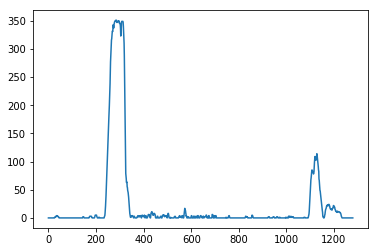

In [10]:
warped_bin = np.zeros_like(warped[:,:,0])
warped_bin[(warped[:,:,0] > 0)] = 1

histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)  # Sum the columns in the bottom half of the image
plt.plot(histogram)

The histogram's primary left and right peaks should be our lane lines. As we follow the lines using a sliding-window search, we will begin our search at these two peaks.

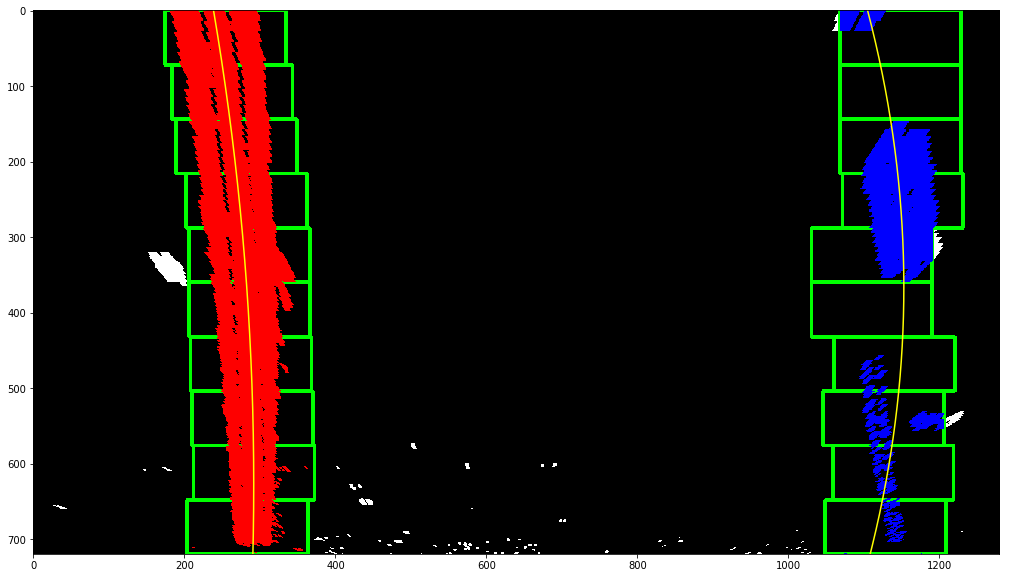

In [11]:
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later

    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 80  # Determines how wide the window is
    pix_to_recenter = margin*2  # If we find this many pixels in our window we will recenter (too few would be a bad recenter)

    # Find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])

    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)

        # Draw the windows on the vis_img
        rect_color, rect_thickness = (0, 255, 0), 3
        cv2.rectangle(vis_img, (win_x_left_low, win_y_high), (win_x_left_high, win_y_low), rect_color, rect_thickness)
        cv2.rectangle(vis_img, (win_x_right_low, win_y_high), (win_x_right_high, win_y_low), rect_color, rect_thickness)

        # Record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)

        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)

    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]

    # Color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later

    # Fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]

    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  # This basically removes everything except the colored lane lines
    
    return y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img

y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img = find_lane(warped, show=True)

Sweet! Looks like we were able to identify the lines. A few things happened here as shown in the image above:
1. The left (red) and right (blue) lines were colored to show the pixels we identified as part of the lines.
2. The sliding windows we used for the line searches are shown at each step in green.
3. The 2nd-degree polynomial lines that fits each line are shown in yellow.

### Step 5: Warp back and draw lane and lines on original image

With the lane lines identified in the last step, it's time to wrap up the pipeline by taking that information and drawing it back onto the original image. This will in involve a reverse perspective transform, since the line/lane information was found from a warped perspective.

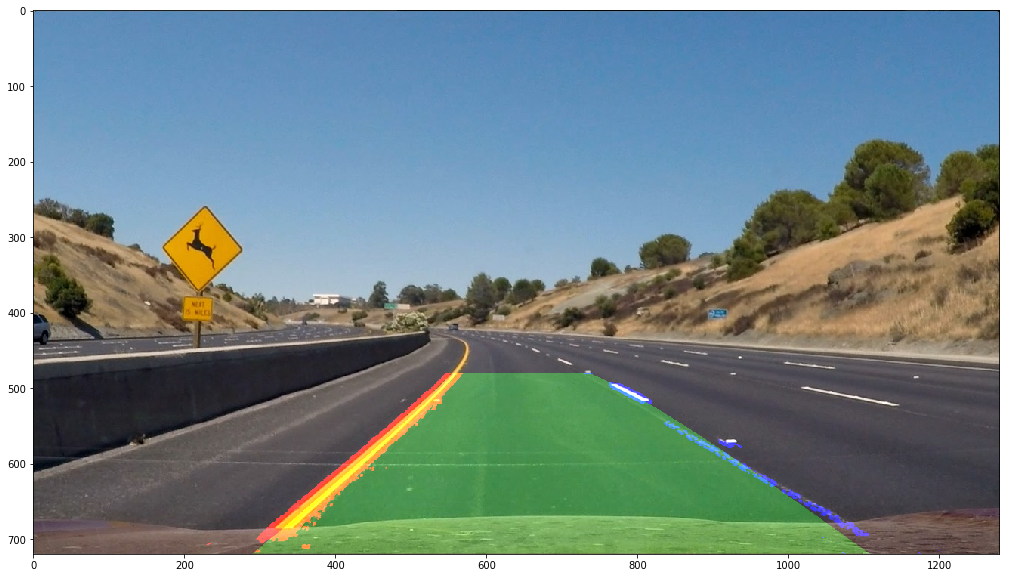

In [12]:
def draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([left_x_vals, y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([right_x_vals, y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    lane = np.zeros_like(lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane_lines_img, 1, lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    
    if show: big_plot(drawn_img)
        
    return drawn_img

drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=True)

# Piecing it all together
### The Complete pipeline

With all the individual parts of the lane-detection pipeline complete, all that remains is to combine them into a single pipeline function.

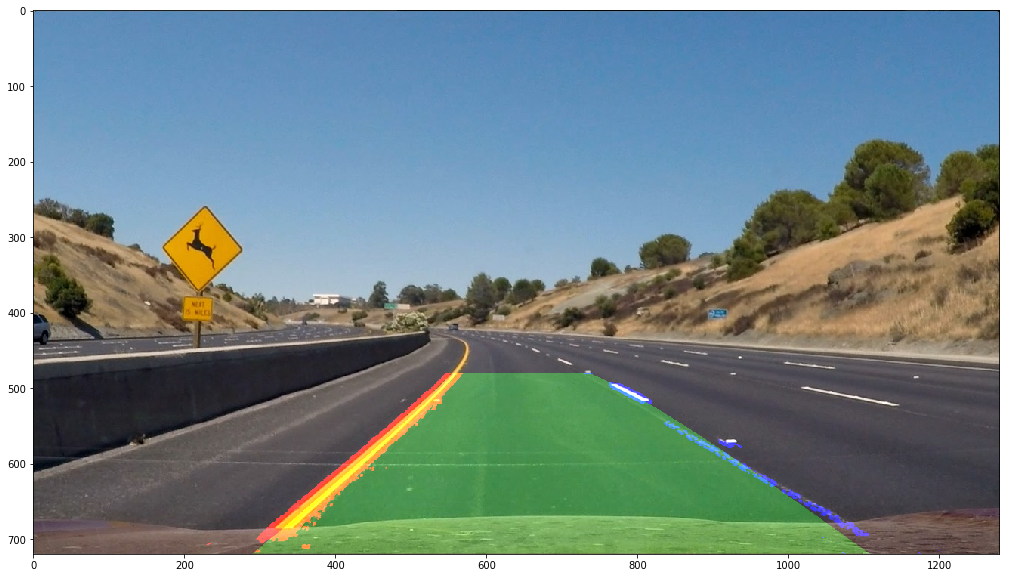

In [13]:
def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img = find_lane(warped)
    drawn_img = draw_lane(img, lane_lines_img, y_vals, left_x_vals, right_x_vals, show=show)
    return drawn_img
    
    
drawn_img = detect_lane_pipe('./test_images/test2.jpg', show=True)

And there it is. 'detect_lane_pipe()' is our complete pipeline function for taking an image path and detecting the lane in that image.

All those parameters being passed around is becoming a bit unwieldy. Let's consolidate them into a Lane class that will track information about the lane we detected in an image.

### The Lane Class

Not only will the Lane class be helpful for consolidating code, but it will also be useful later when we apply our pipeline to videos, frame by frame. For now, the focus will be code consolidation.

In [14]:
class Lane():
    def __init__(self, y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img):
        self.y_vals = y_vals
        self.left_x_vals = left_x_vals
        self.right_x_vals = right_x_vals
        self.left_fit = left_fit
        self.right_fit = right_fit
        self.lane_lines_img = lane_lines_img

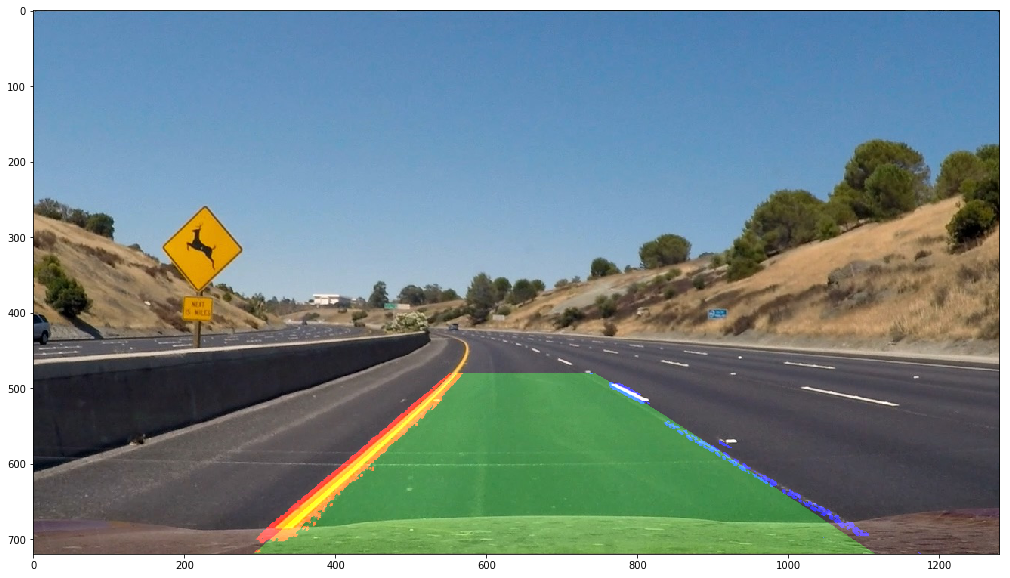

In [15]:
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later

    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 50  # Determines how wide the window is
    pix_to_recenter = margin*2  # If we find this many pixels in our window we will recenter (too few would be a bad recenter)

    # Find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])

    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)

        # Draw the windows on the vis_img
        rect_color, rect_thickness = (0, 255, 0), 3
        cv2.rectangle(vis_img, (win_x_left_low, win_y_high), (win_x_left_high, win_y_low), rect_color, rect_thickness)
        cv2.rectangle(vis_img, (win_x_right_low, win_y_high), (win_x_right_high, win_y_low), rect_color, rect_thickness)

        # Record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)

        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)

    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]

    # Color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later

    # Fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]

    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  # This basically removes everything except the colored lane lines
    
    # NEW - we can now just return a Lane obj
    return Lane(y_vals, left_x_vals, right_x_vals, left_fit, right_fit, lane_lines_img)


# NEW - This function can now accept a Lane obj
def draw_lane(img, lane, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([lane.left_x_vals, lane.y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([lane.right_x_vals, lane.y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    filled_lane = np.zeros_like(lane.lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(filled_lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane.lane_lines_img, 1, filled_lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    
    if show: big_plot(drawn_img)
        
    return drawn_img


def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    if type(img) is str: img = mpimg.imread(img)
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)  # NEW - using the new lane class
    return draw_lane(img, lane, show=show)  # NEW - using the new lane class

drawn_img = detect_lane_pipe('./test_images/test2.jpg', show=True)

Now the pipeline identifies the lane while using the Lane class. This makes the code a little cleaner and allows us to store and use previous lane information.

## The Why

Ok, so we have some code that's neat and makes a cool image, but is it *useful*? How do we use this code or image to direct a self-driving car? It turns out we can use the fit lines for each lane line to accomplish two things:
1. Determine how far from center-of-lane the car is, and
2. Measure the curvature of the road.

Measuring the curvature of the lane and how far the car is from the center of the lane helps us determine steering angles. 

Let's take a look at how we'll get these values.

### Measuring Lane Curvature and Vehicle Offset

We'll want to add the curvature and offset values to the Lane class, so we'll expand it a bit. In the process, let's remove the constructor arguments, because that's getting a bit unwieldy too.

After that, we'll expand the "find_lane()" function to also calculate these new values and add them to the Lane class it already returns.

Finally, we'll display these new values in text on the final drawn image.

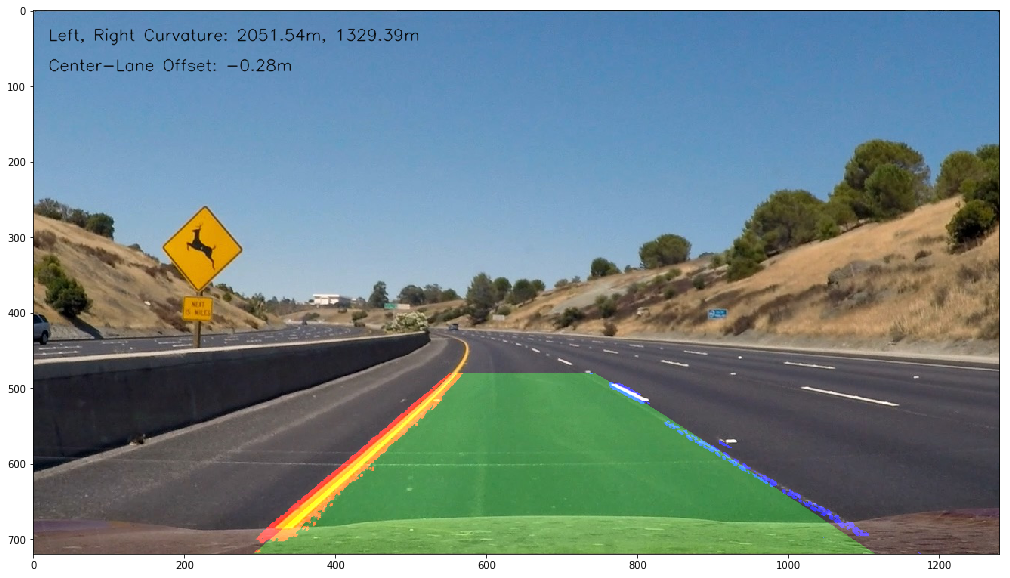

In [16]:
class Lane():
    def __init__(self):
        self.y_vals = None
        self.left_x_vals = None
        self.right_x_vals = None
        self.lane_lines_img = None
        self.left_curvature = None
        self.right_curvature = None
        self.offset = None


def calc_curvature(y_to_fit, x_to_fit, y_eval):
    # Conversion factors for pixels to meters
    m_per_pix_y, m_per_pix_x = 30/720, 3.7/700
    
    # Fit a new polynomial to world-space (in meters)
    fit = np.polyfit(y_to_fit*m_per_pix_y, x_to_fit*m_per_pix_x, 2)
    curvature = ((1 + (2*fit[0]*(y_eval*m_per_pix_y) + fit[1])**2)**1.5) / np.absolute(2*fit[0])
    return curvature


def calc_offset(left_x, right_x, img_center_x):
    lane_width = abs(left_x - right_x)
    lane_center_x = (left_x + right_x)//2
    pix_offset = img_center_x - lane_center_x
    
    lane_width_m = 3.7  # How wide we expect the lane to be in meters
    return lane_width_m * (pix_offset/lane_width)
        
        
def find_lane(warped, show=False):
    # Create a binary version of the warped image
    warped_bin = np.zeros_like(warped[:,:,0])
    warped_bin[(warped[:,:,0] > 0)] = 1
    
    vis_img = warped.copy()  # The image we will draw on to show the lane-finding process
    vis_img[vis_img > 0] = 255  # Max out non-black pixels so we can remove them later

    # Sum the columns in the bottom portion of the image to create a histogram
    histogram = np.sum(warped_bin[warped_bin.shape[0]//2:,:], axis=0)
    # Find the left an right right peaks of the histogram
    midpoint = histogram.shape[0]//2
    left_x = np.argmax(histogram[:midpoint])  # x-position for the left window
    right_x = np.argmax(histogram[midpoint:]) + midpoint  # x-position for the right window

    n_windows = 10
    win_height = warped_bin.shape[0]//n_windows
    margin = 50  # Determines how wide the window is
    pix_to_recenter = margin*2  # If we find this many pixels in our window we will recenter (too few would be a bad recenter)

    # Find the non-zero x and y indices
    nonzero_ind = warped_bin.nonzero()
    nonzero_y_ind = np.array(nonzero_ind[0])
    nonzero_x_ind = np.array(nonzero_ind[1])

    left_line_ind, right_line_ind = [], []

    for win_i in range(n_windows):
        win_y_low = warped_bin.shape[0] - (win_i+1)*win_height
        win_y_high = warped_bin.shape[0] - (win_i)*win_height
        win_x_left_low = max(0, left_x - margin)
        win_x_left_high = left_x + margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(warped_bin.shape[1]-1, right_x + margin)

        # Draw the windows on the vis_img
        rect_color, rect_thickness = (0, 255, 0), 3
        cv2.rectangle(vis_img, (win_x_left_low, win_y_high), (win_x_left_high, win_y_low), rect_color, rect_thickness)
        cv2.rectangle(vis_img, (win_x_right_low, win_y_high), (win_x_right_high, win_y_low), rect_color, rect_thickness)

        # Record the non-zero pixels within the windows
        left_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_left_low) &
            (nonzero_x_ind <= win_x_left_high)
        ).nonzero()[0]
        right_ind = (
            (nonzero_y_ind >= win_y_low) &
            (nonzero_y_ind <= win_y_high) &
            (nonzero_x_ind >= win_x_right_low) &
            (nonzero_x_ind <= win_x_right_high)
        ).nonzero()[0]
        left_line_ind.append(left_ind)
        right_line_ind.append(right_ind)

        # If there are enough pixels, re-align the window
        if len(left_ind) > pix_to_recenter:
            left_x = int(np.mean(nonzero_x_ind[left_ind]))
        if len(right_ind) > pix_to_recenter:
            right_x = int(np.mean(nonzero_x_ind[right_ind]))

    # Combine the arrays of line indices
    left_line_ind = np.concatenate(left_line_ind)
    right_line_ind = np.concatenate(right_line_ind)

    # Gather the final line pixel positions
    left_x = nonzero_x_ind[left_line_ind]
    left_y = nonzero_y_ind[left_line_ind]
    right_x = nonzero_x_ind[right_line_ind]
    right_y = nonzero_y_ind[right_line_ind]

    # Color the lines on the vis_img
    vis_img[left_y, left_x] = [254, 0, 0]  # 254 so we can isolate the white 255 later
    vis_img[right_y, right_x] = [0, 0, 254]  # 254 so we can isolate the white 255 later
    
    # Fit a 2nd-order polynomial to the lines
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)

    # Get our x/y vals for the fit lines
    y_vals = np.linspace(0, warped_bin.shape[0]-1, warped_bin.shape[0])
    left_x_vals = left_fit[0]*y_vals**2 + left_fit[1]*y_vals + left_fit[2]
    right_x_vals = right_fit[0]*y_vals**2 + right_fit[1]*y_vals + right_fit[2]
    
    # Calculate real-world curvature for each lane line
    left_curvature = calc_curvature(left_y, left_x, np.max(y_vals))
    right_curvature = calc_curvature(right_y, right_x, np.max(y_vals))
    # Calculate the center-lane offset of the car
    offset = calc_offset(left_x_vals[-1], right_x_vals[-1], warped.shape[1]//2)

    if show:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(vis_img)
        ax.plot(left_x_vals, y_vals, color='yellow')
        ax.plot(right_x_vals, y_vals, color='yellow')
        
    lane_lines_img = vis_img.copy()
    lane_lines_img[lane_lines_img == 255] = 0  # This basically removes everything except the colored lane lines
    
    # Build the Lane object to return
    lane = Lane()
    lane.y_vals = y_vals
    lane.left_x_vals = left_x_vals
    lane.right_x_vals = right_x_vals
    lane.lane_lines_img = lane_lines_img
    lane.left_curvature = left_curvature
    lane.right_curvature = right_curvature
    lane.offset = offset
    
    return lane
        
    
def draw_values(img, lane, show=False):
    font = cv2.FONT_HERSHEY_SIMPLEX
    scale = .7
    color =  (0, 0, 0)
    line_type = cv2.LINE_AA
    cv2.putText(
        img,
        'Left, Right Curvature: {:.2f}m, {:.2f}m'.format(lane.left_curvature, lane.right_curvature),
        (20, 40),  # origin point
        font,
        scale,
        color,
        lineType=line_type
    )
    cv2.putText(
        img,
        'Center-Lane Offset: {:.2f}m'.format(lane.offset),
        (20, 80),  # origin point
        font,
        scale,
        color,
        lineType=line_type
    )
    
    if show: big_plot(img)
    
    return img
    
    
def draw_lane(img, lane, show=False):
    # Prepare the x/y points for cv2.fillPoly()
    left_points = np.array([np.vstack([lane.left_x_vals, lane.y_vals]).T])
    right_points = np.array([np.flipud(np.vstack([lane.right_x_vals, lane.y_vals]).T)])
    # right_points = np.array([np.vstack([right_x_vals, y_vals]).T])
    points = np.hstack((left_points, right_points))

    # Color the area between the lines (the lane)
    filled_lane = np.zeros_like(lane.lane_lines_img)  # Create a blank canvas to draw the lane on
    cv2.fillPoly(filled_lane, np.int_([points]), (0, 255, 0))
    warped_lane_info = cv2.addWeighted(lane.lane_lines_img, 1, filled_lane, .3, 0)

    unwarped_lane_info = cv2.warpPerspective(warped_lane_info, Minv, (img.shape[1], img.shape[0]))
    drawn_img = cv2.addWeighted(img, 1, unwarped_lane_info, 1, 0)
    drawn_img = draw_values(drawn_img, lane)
    
    if show: big_plot(drawn_img)
        
    return drawn_img


drawn_img = detect_lane_pipe('./test_images/test2.jpg', show=True)

Great! The image displays like normal, but now the curvature and offset measurements are displayed in the top-left corner.

## Thinking about Videos

Using this pipeline we could annotate entire videos of driving frame-by-frame.

Unforunately, not all frames of the video provide us with enough information to perfectly detect the lane. To prevent erratic behavior, we need to implement some notion of filtering and smoothing. Basically, we'll assume things don't change drastically, and if they do then we resume previous behavior.

### Filtering and Smoothing

For filtering we need to look at previous Lane detections and determine whether the current Lane detection is appropriate. If the current is too far off from the previous, something's wrong.

For smoothing we will use as a final result the average of the current and previously stored findings. This will ensure our updates don't differ sharply from the previous result and will produce a smoother video.

In [17]:
# Filtering - Tests whether a new lane is appropriate compared to previously found lanes
def is_good_lane(lane):
    global prev_lanes
    
    good_line_diff = True
    good_lane_area = True
    
    # Measure the total x-pixel difference between the new and the old
    if len(prev_lanes) > 0:  # If we don't have any previous lanes yet, just assume True
        prev_x_left = prev_lanes[0].left_x_vals
        prev_x_right = prev_lanes[0].right_x_vals
        current_x_left = lane.left_x_vals
        current_x_right = lane.right_x_vals

        left_diff = np.sum(np.absolute(prev_x_left - current_x_left))
        right_diff = np.sum(np.absolute(prev_x_right - current_x_right))

        lane_pixel_margin = 50  # How much different the new lane's x-values can be from the last lane
        diff_threshold = lane_pixel_margin*len(prev_x_left)

        if left_diff > diff_threshold or right_diff > diff_threshold:
            print(diff_threshold, int(left_diff), int(right_diff))
            print()
            good_line_diff = False
    
    # Make sure the area between the lane lines is appropriate (not too small or large)
    lane_area = np.sum(np.absolute(np.subtract(lane.right_x_vals, lane.left_x_vals)))
    area_min, area_max = 400000, 800000  # Area thesholds
    if lane_area < area_min or lane_area > area_max:
        print('Bad lane area:', lane_area)
        good_lane_area = False
    
    return (good_line_diff and good_lane_area)


# Smoothing - Averages the stored lanes for a smoothing effect
def get_avg_lane():
    global prev_lanes
    
    if len(prev_lanes) == 0: return None
    elif len(prev_lanes) == 1: return prev_lanes[0]
    else:  # More than 1 previous result to average together
        n_lanes = len(prev_lanes)
        new_lane = prev_lanes[0]
        
        avg_lane = Lane()  # The averaged lane we will return (with some defaults)
        avg_lane.y_vals = new_lane.y_vals
        avg_lane.lane_lines_img = new_lane.lane_lines_img

        # Average the left and right lanes' x-values
        left_avg = new_lane.left_x_vals
        right_avg = new_lane.right_x_vals
        for i in range(1, n_lanes):
            left_avg = np.add(left_avg, prev_lanes[i].left_x_vals)
            right_avg = np.add(right_avg, prev_lanes[i].right_x_vals)

        avg_lane.left_x_vals = left_avg / n_lanes
        avg_lane.right_x_vals = right_avg / n_lanes
        
        # Average the curvatures and offsets
        avg_lane.left_curvature = sum([lane.left_curvature for lane in prev_lanes])/n_lanes
        avg_lane.right_curvature = sum([lane.right_curvature for lane in prev_lanes])/n_lanes
        avg_lane.offset = sum([lane.offset for lane in prev_lanes])/n_lanes

        return avg_lane


def detect_lane_pipe(img, show=False):
    ''' "img" can be a path or a loaded image (for the movie pipeline) '''
    
    global prev_lanes
    global n_bad_lanes
    
    if type(img) is str: img = mpimg.imread(img)
        
    n_lanes_to_keep = 5
    # To speed up processing, if we've had an easy time detecting the lane, do half the updates
    if len(prev_lanes) == n_lanes_to_keep and n_bad_lanes == 0:
        n_bad_lanes += 1
        return draw_lane(img, get_avg_lane(), show=show)
        
    undist = undistort(img)
    threshed = get_threshold(undist)
    warped, M, Minv = warp_to_lines(threshed)
    lane = find_lane(warped)
    
    if is_good_lane(lane):  # If the lane is good (compared to previous lanes), add it to the list
        n_bad_lanes = 0
        prev_lanes.insert(0, lane)
        if len(prev_lanes) > n_lanes_to_keep: prev_lanes.pop()
    else:
        n_bad_lanes += 1
        
    # If we get stuck on some bad lanes, don't reinforce it, just clear them out.
    if n_bad_lanes >= 12:
        print('Resetting: too many bad lanes.')
        n_bad_lanes = 0
        prev_lanes = []
        
    # If we start with some bad lanes, this will just skip the drawing
    if len(prev_lanes) == 0: return img
            
    return draw_lane(img, get_avg_lane(), show=show)

Great! "is_good_lane()" tells us whether the lane was appropriate based on two factors:
1. How much (in the x-direction) the new fit lines differed from the previous fit lines.
2. How much "area" the lane covers.

"get_avg_lane()" does exactly that - it averages the current and previous fit lines together to create a smoothing effect so the lane doesn't jump around and look jittery.

While single-image processing won't make use of the filtering and smoothing functions just implemented, let's make sure the pipeline still works as expected.

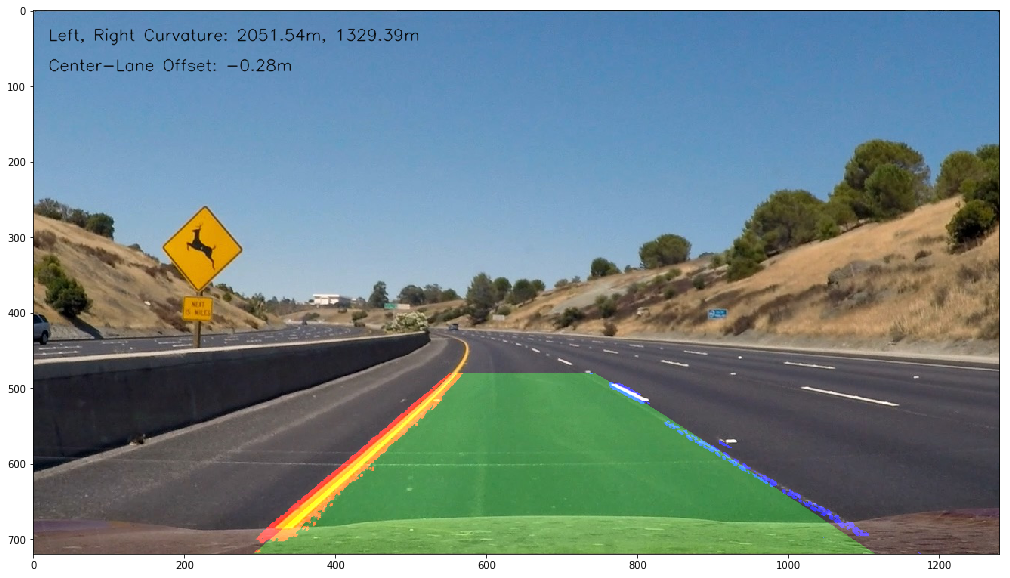

In [18]:
n_bad_lanes = 0
prev_lanes = []
drawn_img = detect_lane_pipe('./test_images/test2.jpg', show=True)

With the pipeline still working as expected for single images, it's time to test the filtering and smoothing functions on some videos.

### Finally - The Videos!

To annotate an entire video we will use the convenient "moviepy" library. It will load an existing video file, break it up into frames, pass each frame through the lane detection pipeline, and then stitch them all back together into a new video. Let's get to it!

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
n_bad_lanes = 0
prev_lines = []

f_name = 'project_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
# video = video.subclip(39, 43)  # Only process a portion
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

In [ ]:
# Challenge Video 1
n_bad_lanes = 0
prev_lines = []

f_name = 'challenge_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
# video = video.subclip(39, 43)  # Only process a portion
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

In [ ]:
# Challenge Video 2
n_bad_lanes = 0
prev_lines = []

f_name = 'harder_challenge_video.mp4'
video = VideoFileClip('./videos/{}'.format(f_name))  # Load the original video
video = video.fl_image(detect_lane_pipe)  # Pipe the video frames through the lane-detection pipeline
# video = video.subclip(0, 10)  # Only process a portion
%time video.write_videofile('./videos_out/{}'.format(f_name), audio=False)  # Write the new video

The video outputs are available in the project repo in the "videos_out" folder.
They can also be viewed on YouTube:
* [Project Video](https://youtu.be/v_leQokpNnU)
* [Challenge Video](https://youtu.be/YIfH7aO-D_4)
* [Hard Challenge Video](https://youtu.be/3lMie0rdx4E)

## Shortcomings and Future Improvements

**Project Video**

If you look at the videos, the pipeline works very well on the standard project video. I'm very happy the pipeline doesn't cut out on either of the bridges where the pavement color changes and there are lots of shadows. One thing I noticed while developing the pipeline on this video is that the s-channel image, while normally better, isn't sufficient for the Sobel-gradient when thresholding. However, calculating the Sobel-gradient using both grey *and* s-channel images enabled the lines to be reliably detected.

**Challenge Video**

The pipeline actually does pretty decent in the challenge video, too, but a couple things cause it to slip up.

First, there are vertical lines in the pavement either where two different pavement types have been joined (even different colors) or where the pavement has been damaged. Sometimes the pipeline confuses the right dotted lane for these other lines. It helped with this problem when I implemented lane-area filtering, but it's still not perfect. I think limiting the area in which lines are searched for might solve this problem.

Second, the underpass causes a huge loss of light, making the lanes VERY difficult to detect. I didn't experiment with thresholding techniques on images from this area, but that's where I would start to solve the issue. I'm a little skeptical that thresholding alone would solve it, though.

**Harder Challenge Video**

The harder challenge video lives up its name! The pipeline doesn't do well on this one. While I might feel save in a car using my pipeline on the first challenge video's road, I'm not going anywhere a car using my pipeline on the harder challenge video's road! There are two things to note about the harder challenge video.

First, the pipeline clearly has the most trouble with the sharper turns. In part, I think this could be fixed by tweaking the perspective warp area. I didn't check, but I bet for the sharp turns a lot of one of the lines isn't even in the image to be detected. I think a harder but more robust solution for this problem is to either turn the camera with the car or use more cameras. On a sharp right turn, a camera facing that direction (perhaps with a better perspective, too) would provide better information.

Second, due to all the trees, the lighting varies drastically in this image. Sometimes you actually see the interior of the car due to the glare. Unexpectedly, this causes isssues. I was actually surprised to find that the pipeline wasn't too thrown off by this. *Maybe* some thresholding changes would help, but even from a human perspective those kinds of conditions can be difficult. Using more or different sensors would be one option. For a camera-only solution, techniques to remember and anticipate better could be implemented so that a future-looking plan could be executed when the sensors aren't providing good data.